## AML 2304 Lab 3 - Group E

In [1]:
import os
import pandas as pd
import email
import re
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from email import policy
from email.header import decode_header
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, classification_report

nltk.download('wordnet')
pd.set_option('max_colwidth', 100)

%matplotlib inline
rcParams['figure.figsize'] = 5,3

warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aurad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read file contents from Dataset main folder. Extract the `SUBJECT`, `TO`, `FROM` and `EMAIL BODY` from the email, then add the data in dataframe with the correct label: `spam` or `ham`

In [2]:
def get_email_body(msg):
    email_body = ""

    if "multipart" in msg.get_content_type():

        for part in msg.get_payload(decode=False):
            if not isinstance(part, str):
                email_part = str(part.get_payload(decode=False)).strip()
                email_body = email_body + email_part
    else:
        email_body = str(msg.get_payload(decode=False)).strip()

    return email_body


try:
    data_raw_df = pd.DataFrame(columns=['subject', 'to', 'from', 'email_body', 'label'])

    labels = ['ham', 'spam']
    for idx in range(len(labels)):

        spam_dir = "Dataset/" + labels[idx] + "/"
        # Read all files from the dataset folder
        for file in os.listdir(spam_dir)[:]:
            with open(spam_dir + file, "r", encoding="latin-1") as f:
                # Parse the email messages
                msg = email.message_from_string(f.read(), policy=policy.default)

                email_to = str(decode_header(msg.get('to'))[0][0]) if msg.get('to') is not None else ''
                email_from = str(decode_header(msg.get('from'))[0][0]) if msg.get('to') is not None else ''
                subject = str(decode_header(msg.get('subject'))[0][0]) if msg.get('subject') is not None else ''
                email_body = get_email_body(msg)

                # Add label to your record: 0 = ham, 1 = spam
                new_data = [subject, email_to, email_from, email_body, idx]
                data_raw_df.loc[len(data_raw_df)] = new_data

    display(data_raw_df.head(5))

except Exception as err:
    print(f"Error: {err} - filename: {file}")

,subject,to,from,email_body,label
0,Re: New Sequences Window,Chris Garrigues <cwg-dated-1030314468.7c7c85@DeepEddy.Com>,Robert Elz <kre@munnari.OZ.AU>,"Date: Tue, 20 Aug 2002 17:27:47 -0500\n From: Chris Garrigues <cwg-exmh@DeepEdd...",0
1,Re: New Sequences Window,Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>,Robert Elz <kre@munnari.OZ.AU>,"Date: Wed, 21 Aug 2002 10:54:46 -0500\n From: Chris Garrigues <cwg-dated-103037...",0
2,Personal Finance: Resolutions You Can Keep,mkettler@home.com,The Motley Fool <Fool@motleyfool.com>,======================== THE MOTLEY FOOL ========================\n PERSO...,0
3,Re: New Sequences Window,Valdis.Kletnieks@vt.edu,Chris Garrigues <cwg-exmh@DeepEddy.Com>,"> From: Valdis.Kletnieks@vt.edu\n> Date: Wed, 21 Aug 2002 02:36:56 -0400\n>\n> --==_Exmh_77858...",0
4,[zzzzteana] RE: Alexander,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoogroups.com>",Steve Burt <Steve_Burt@cursor-system.com>,"Martin A posted:\nTassos Papadopoulos, the Greek sculptor behind the plan, judged that the\n lim...",0


## Exploratory Data Analysis (incl. cleaning the data)

In [3]:
# Check if there are null values
print(data_raw_df.isnull().sum())

subject       0
to            0
from          0
email_body    0
label         0
dtype: int64


[Text(0, 0, '0: Ham (6701)'), Text(1, 0, '1: Spam (1896)')]

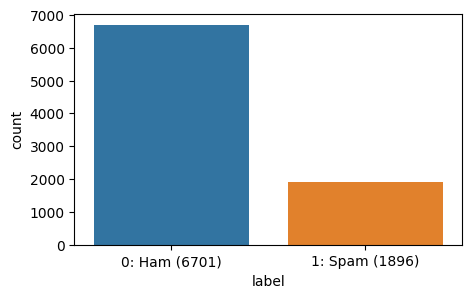

In [4]:
countplt = sns.countplot(x='label', data=data_raw_df)
countplt.set_xticklabels(['0: Ham (' + str(data_raw_df['label'].value_counts()[0]) + ")", '1: Spam (' + str(data_raw_df['label'].value_counts()[1]) + ')'])

Convert all characters to lower case before cleaning the data

In [5]:
# This variable will contain the cleaned data
data_cleaned_df = data_raw_df.copy()

data_cleaned_df = data_cleaned_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
data_cleaned_df.head(5)

,subject,to,from,email_body,label
0,re: new sequences window,chris garrigues <cwg-dated-1030314468.7c7c85@deepeddy.com>,robert elz <kre@munnari.oz.au>,"date: tue, 20 aug 2002 17:27:47 -0500\n from: chris garrigues <cwg-exmh@deepedd...",0
1,re: new sequences window,chris garrigues <cwg-dated-1030377287.06fa6d@deepeddy.com>,robert elz <kre@munnari.oz.au>,"date: wed, 21 aug 2002 10:54:46 -0500\n from: chris garrigues <cwg-dated-103037...",0
2,personal finance: resolutions you can keep,mkettler@home.com,the motley fool <fool@motleyfool.com>,======================== the motley fool ========================\n perso...,0
3,re: new sequences window,valdis.kletnieks@vt.edu,chris garrigues <cwg-exmh@deepeddy.com>,"> from: valdis.kletnieks@vt.edu\n> date: wed, 21 aug 2002 02:36:56 -0400\n>\n> --==_exmh_77858...",0
4,[zzzzteana] re: alexander,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoogroups.com>",steve burt <steve_burt@cursor-system.com>,"martin a posted:\ntassos papadopoulos, the greek sculptor behind the plan, judged that the\n lim...",0


Extract mail server and domain name from `TO` and `FROM`

Notes: Some values are marked as "undisclosed-recipient" for `TO`, resulting for blank text after extraction 

In [6]:
def extract_mail_server_and_domain(text):
    email_list = []
    email_tokens = text.split(",")

    for email in email_tokens:
        match = re.search(r'@([\w.]+\.[a-z]{2,})', email)
        if match:
            email_list.append(match.group(1))

    return email_list

data_cleaned_df[['to', 'from']] = data_cleaned_df[['to', 'from']].applymap(extract_mail_server_and_domain)
data_cleaned_df[['to', 'from']].head(5)

,to,from
0,[deepeddy.com],[munnari.oz.au]
1,[deepeddy.com],[munnari.oz.au]
2,[home.com],[motleyfool.com]
3,[vt.edu],[deepeddy.com]
4,[yahoogroups.com],[]


Get top 50 words with highest frequency for `TO` and `FROM`

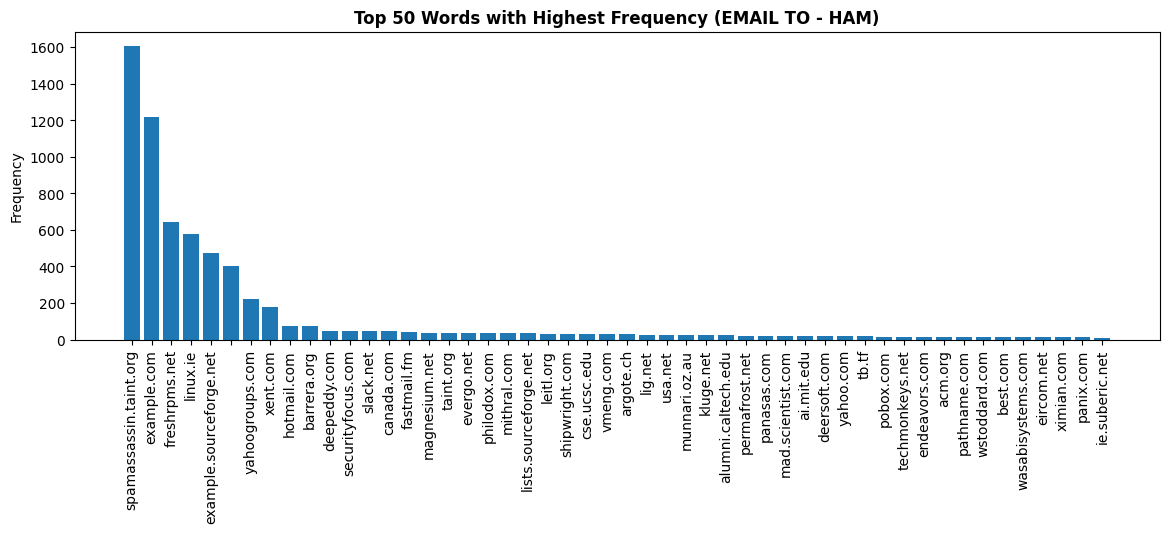

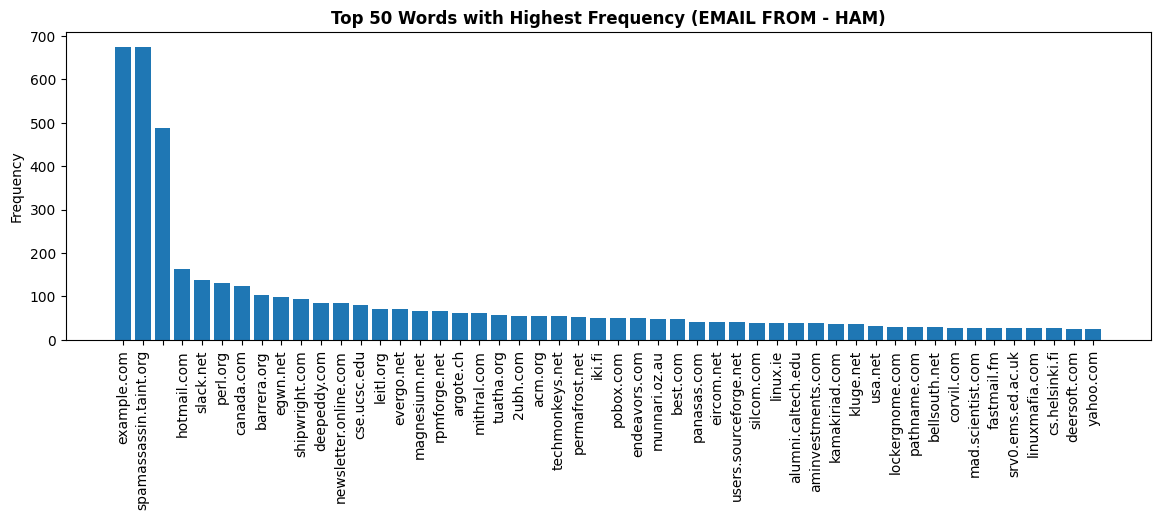

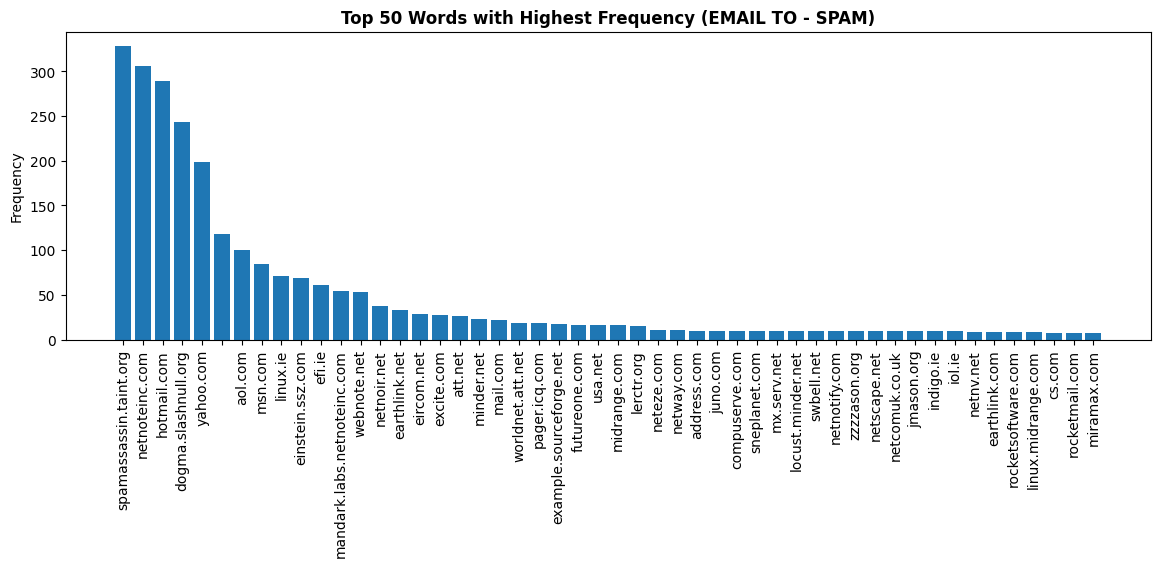

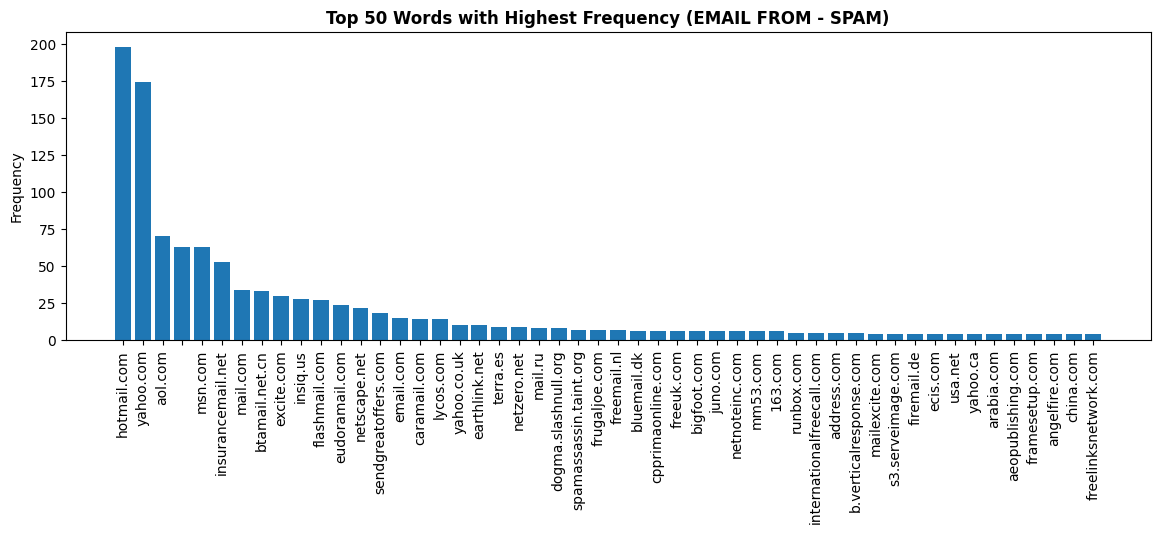

In [7]:
for idx, label in enumerate(labels):
    columns = ['to', 'from']

    for column in columns:
        email = data_cleaned_df[column][data_cleaned_df['label'] == idx]
        combined_emails = ','.join(email.apply(lambda x : ','.join(x)))
        email_list = combined_emails.split(",")
        email_counts = Counter(email_list)
        top_50_words = email_counts.most_common(50)

        # Separate the words and their counts for plotting
        top_words, counts = zip(*top_50_words)

        # Create a bar graph
        plt.figure(figsize=(14, 4))
        plt.bar(top_words, counts)
        plt.ylabel('Frequency')
        plt.title('Top 50 Words with Highest Frequency (EMAIL ' + column.upper() + ' - ' + label.upper() + ')', weight='bold')
        plt.xticks(rotation=90)
        plt.show()

For `SUBJECT` and `EMAIL_BODY`, the following will be applied to clean the data
- Remove email addresses and URLs
- Remove HTML tags and scripting variable names
- Replace all whitespaces with space
- Handling contractions
- Remove special characters and numbers
- Tokenization, stopwords removal and lemmatization
- Handling typos and mispellings (?)
- Remove words that are not in dictionary (?)

In [8]:
pd.set_option('max_colwidth', None)

stop_words = set(stopwords.words('english'))

def remove_unnecessary_words(text):
    # Remove email addresses
    pattern_email = r'\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,7}\b'    
    text = re.sub(pattern_email, '', text)

    # Remove URLs
    pattern_url = r'https?://(?:www\.)?[\w\.-]+(?:\.[a-z]{2,})+(?:/[-\w\.,/]*)*(?:\?[\w\%&=]*)?'
    text = re.sub(pattern_url, '', text)

    # Handle contractions
    text = contractions.fix(text)

    # Remove HTML tags
    pattern_html = r'<[^>]+>'
    text = re.sub(pattern_html, '', text)
    text = text.replace('&nbsp;', ' ')

    # Remove scripting variable names, e.g. $msg
    pattern_scripting = r'\$\w+\s*'
    text = re.sub(pattern_scripting, '', text)

    # Remove all special characters and numbers
    pattern_special_num = r'(?<![a-z])-(?![a-z])|[^a-z\s-]+'
    text = re.sub(pattern_special_num, ' ', text)

    # Replace all whitespaces (new lines, tabs, etc.) to space
    pattern_whitespace = r'\s+'
    text = re.sub(pattern_whitespace, ' ', text)

    # Tokenize the text and remove stopwords
    word_list = [word for word in word_tokenize(text) if word not in stop_words]    

    return word_list


data_cleaned_df[['subject', 'email_body']] = data_cleaned_df[['subject', 'email_body']].applymap(remove_unnecessary_words)

display(data_cleaned_df.head(2))
display(data_cleaned_df.tail(2))

,subject,to,from,email_body,label
0,"[new, sequences, window]",[deepeddy.com],[munnari.oz.au],"[date, tue, aug, chris, garrigues, message-id, hoping, people, additional, sequences, notice, purely, cosmetic, changes, well, first, exmh, latest, one, changes, starts, get, read, flist, totalcount, unseen, element, array, executing, totalcount, unseen-sequence, flaginner, spool, iconspool, labelup, else, flaginner, icondown, labeldown, procedure, flag, msgseen, line, invoked, within, flag, msgseen, procedure, msgseen, line, invoked, within, msgseen, procedure, msgshow, line, invoked, within, msgshow, procedure, msgchange, line, invoked, within, msgchange, show, invoked, within, time, list, msgchange, procedure, msg, change, line, invoked, within, msg, change, id, procedure, msg, show, line, invoked, within, msg, show, cur, eval, body, line, invoked, within, eval, procedure, folderchange, line, invoked, within, ...]",0
1,"[new, sequences, window]",[deepeddy.com],[munnari.oz.au],"[date, wed, aug, chris, garrigues, message-id, reproduce, error, repeatable, like, every, time, without, fail, debug, log, pick, happening, pick, exec, pick, inbox, -list, -lbrace, -lbrace, -subject, ftp, -rbrace, -rbrace, -sequence, mercury, exec, pick, inbox, -list, -lbrace, -lbrace, -subject, ftp, -rbrace, -rbrace, -sequence, mercury, ftoc, pickmsgs, hit, marking, hits, tkerror, syntax, error, expression, int, note, run, pick, command, hand, delta, pick, inbox, -list, -lbrace, -lbrace, -subject, ftp, -rbrace, -rbrace, -sequence, mercury, hit, hit, comes, obviously, version, nmh, using, delta, pick, -version, pick, nmh-, compiled, fuchsia, cs, mu, oz, au, sun, mar, ict, relevant, part, mh, profile, delta, mhparam, pick, -seq, sel, ...]",0


,subject,to,from,email_body,label
8595,"[cannabis, difference]",[webnote.net],[dialix.oz.au],"[mid-summer, customer, appreciation, sale, express, appreciation, loyal, customers, offering, following, products, limited, time, ragga, dagga, stoney, mahoney, sweet, vjestika, aqueous, kathmandu, along, free, oz, package, capillaris, herba, three, new, renegade, botanicals, exotic, botanical, resources, ethnobotanical, herbalists, brought, herba, supplementals, kathmandu, temple, kiff, personal, choice, pipe-smoking, products, substances, common, market, announcing, temple, ragga, dagga, tm, aqueous, kathmandu, tm, stoney, mahoney, tm, temple, ragga, dagga, finally, able, offer, sensitive, responsive, personal, choice, smoking, enjoyment, temple, ragga, dagga, tm, pipe-smoking, substance, supplemental, product, introduced, three, years, research, development, temple, personal, choice, legal, smoking, indulgence, redefined, thanks, recent, dramatic, technological, advances, laboratorial, processes, extraction, ...]",1
8596,"[ilug, wilson, kamela]",[linux.ie],[netscape.net],"[attn, sir, madan, strictly, confidential, pleased, introduce, name, mr, wilson, kamela, native, south, africa, senior, employee, mines, natural, resources, department, currently, trainning, course, holland, months, writing, letter, request, assistance, order, redeem, investment, south, african, mining, corporation, said, investment, valued, million, dollars, fifteen, million, five, hundred, thousand, dollars, purchased, lucio, harper, contracted, south, african, mining, corporation, recognised, mines, natural, resources, department, redeemable, investment, interest, matured, since, march, last, year, since, march, last, year, several, attempts, made, contact, lucio, harper, without, success, way, contact, close, relatives, whose, favour, investment, cash, value, paid, since, access, lucio, harper, information, claim, money, help, partners, south, ...]",1


In [9]:
# Handling typos and mispellings
english_vocab = set(w.lower() for w in words.words())


def lemmatize_word(word, pos=None):
    lemmatizer = WordNetLemmatizer()
    if pos is None:
        return lemmatizer.lemmatize(word)        
    
    return lemmatizer.lemmatize(word, pos=pos)


def suggest_words(word, threshold=3):
    suggested_words = [e_word for e_word in english_vocab if edit_distance(word, e_word) <= threshold]
    return suggested_words


def is_combined_word(word_list, index):
    combined_word = word_list[index] + word_list[index+1]
    lemmatized_word = lemmatize_word(combined_word, 'v')

    # Check if the combined word is in the dictionary and not a stopword
    if lemmatized_word in english_vocab and lemmatized_word not in stop_words:
        word_list[index] = lemmatize_word(combined_word)
        word_list.pop(index+1)
        return True

    return False


def handle_mispelling_words(word_list):
    word_list_size = len(word_list)-1
    idx = 0
    
    while idx < word_list_size:
        # Remove trailing and leading dash(es)
        cleaned_word = re.sub(r'^-+|-+$', '', word_list[idx])

        # Check if any of two consecutive words (current and after) aren't in dictionary and 
        # see if putting them together might work
        if any(word not in english_vocab for word in word_list[idx:idx+2]):
            # Check if two words can be combined
            is_valid_word = is_combined_word(word_list, idx)
            if is_valid_word:
                word_list_size = word_list_size - 1
            else:
                # Remove one-character word from the list
                if len(cleaned_word) == 1:
                    word_list.pop(idx)    
                    word_list_size = word_list_size - 1
                else:
                    # suggested_words = suggest_words(cleaned_word)
                    # TODO: Improve this section of the code
                    # For now, we only take words that have error distance of 3
                    # if len(suggested_words) == 0:
                    #     word_list.pop(idx)    
                    #     word_list_size = word_list_size - 1
                    # else:
                    word_list[idx] = lemmatize_word(cleaned_word)
        else:
            word_list[idx] = lemmatize_word(cleaned_word)
            
        idx = idx + 1

    return word_list


data_cleaned_df[['subject', 'email_body']] = data_cleaned_df[['subject', 'email_body']].applymap(lambda x : handle_mispelling_words(x))
data_cleaned_df[['subject', 'email_body']]

,subject,email_body
0,"[new, sequence, window]","[date, tue, aug, chris, garrigues, message-id, hoping, people, additional, sequence, notice, purely, cosmetic, change, well, first, exmh, latest, one, change, start, get, read, flist, totalcount, unseen, element, array, executing, totalcount, unseen-sequence, flaginner, spool, iconspool, labelup, else, flaginner, icondown, labeldown, procedure, flag, msgseen, line, invoked, within, flag, msgseen, procedure, msgseen, line, invoked, within, msgseen, procedure, msgshow, line, invoked, within, msgshow, procedure, msgchange, line, invoked, within, msgchange, show, invoked, within, time, list, msgchange, procedure, msg, change, line, invoked, within, msg, change, id, procedure, msg, show, line, invoked, within, msg, show, cur, eval, body, line, invoked, within, eval, procedure, folderchange, line, invoked, within, ...]"
1,"[new, sequence, window]","[date, wed, aug, chris, garrigues, message-id, reproduce, error, repeatable, like, every, time, without, fail, debug, log, pick, happening, pick, exec, pick, inbox, list, lbrace, lbrace, subject, ftp, rbrace, rbrace, sequence, mercury, exec, pick, inbox, list, lbrace, lbrace, subject, ftp, rbrace, rbrace, sequence, mercury, ftoc, pickmsgs, hit, marking, hit, tkerror, syntax, error, expression, int, note, run, pick, command, hand, delta, pick, inbox, list, lbrace, lbrace, subject, ftp, rbrace, rbrace, sequence, mercury, hit, hit, come, obviously, version, nmh, using, delta, pick, version, pick, nmh, compiled, fuchsia, c, mu, oz, au, sun, mar, ict, relevant, part, mh, profile, delta, mhparam, pick, seq, sel, ...]"
2,"[personal, finance, resolution, keep]","[motley, fool, personal, finance, wednesday, january, issue, ask, fool, stop, solicitation, money, resolution, keep, spotlight, saving, market, community, tip, least, one, thing, differently, sponsored, datek, datek, online, built, trade, proprietary, auto, routing, technology, commission, online, equity, trade, second, execution, commitment, apply, datek, account, ask, fool, q, tired, getting, many, credit, card, offer, mail, already, card, want, mail, offering, new, one, stop, three, main, credit, bureau, united, state, agreed, someone, contact, one, asks, removed, junk, mail, er, direct, mail, list, telemarketing, phone, list, honor, request, full, answer, money, resolution, keep, let, u, face, new, year, resolution, mostly, nightmare, hang, head, like, ...]"
3,"[new, sequence, window]","[date, wed, aug, exmh, content-type, text, plain, charset, us-ascii, tue, aug, edt, said, ever, tried, get, mh, pseq, sequence, suspect, everybod, looking, big, box, unseen, pseq, might, want, add, pseq, hide, default, list, intended, added, sequence, never, show, list, take, effect, till, stopped, restarted, exmh, added, pseq, hit, save, preference, take, effect, till, restarted, one, point, worked, fine, check, see, stopped, working, chris, chris, garrigues, cwg, vircio, congress, suite, austin, tx, world, war, iii, wrong-doers, v, evil-doers, begin, pgp, signature, version, gnupg, v, gnu, linux, comment, exmh, version, id, dbqe, gk, b, h, iuirasiyaj, zejm, tiqdd, mqu, lbapzzpasgcccjtl, bdfb, wkmtagwylf, ...]"
4,"[zzzzteana, alexander]","[martin, posted, tasso, papadopoulos, greek, sculptor, behind, plan, judged, limestone, mount, kerdylio, mile, east, salonika, far, mount, athos, monastic, community, ideal, patriotic, sculpture, well, alexander, granite, feature, ft, high, ft, wide, museum, restored, amphitheatre, car, park, admiring, crowd, planned, mountain, limestone, granite, limestone, weather, pretty, fast, yahoo, group, sponsor, dvd, free, p, join, unsubscribe, group, send, email, use, yahoo, group, subject]"
...,...,...
8592,"[busy, home, study, make, sense]","[want, bos, train, self-paced, home, study, thousand, people, people, like, able, work, home, thanks, convenience, distance, learning, course, pcdi, bonus, tuition, discount, enroll, pcdi, offer, popular, career, training, program, inclu

Compare word clout of raw and cleaned data

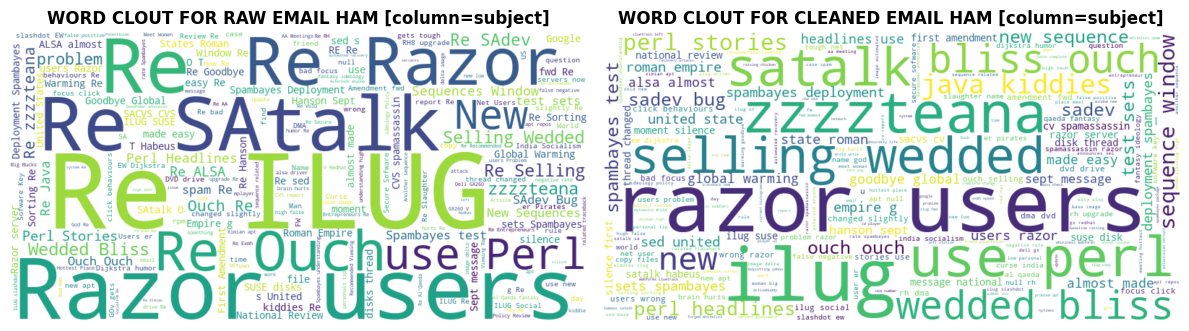

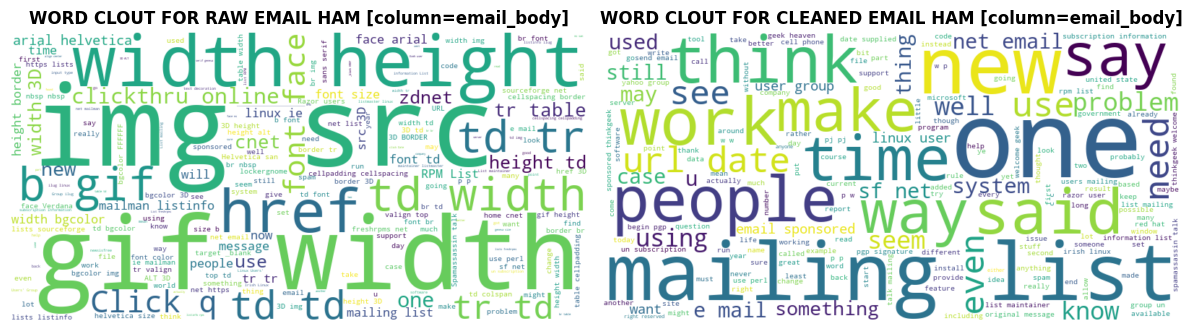

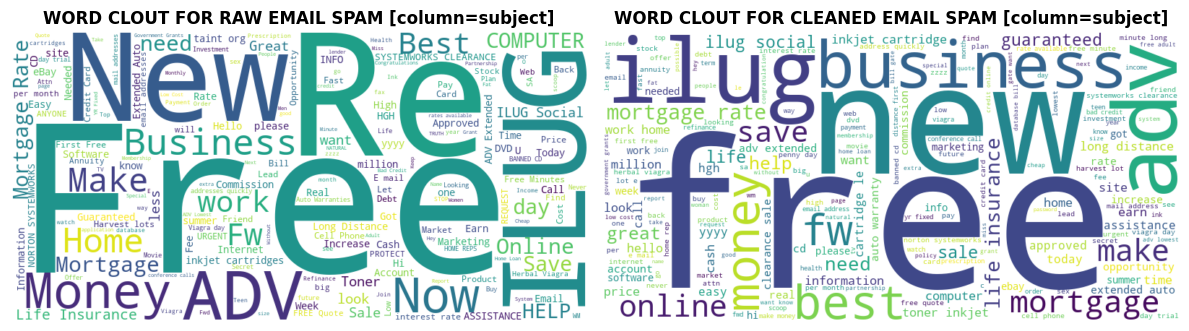

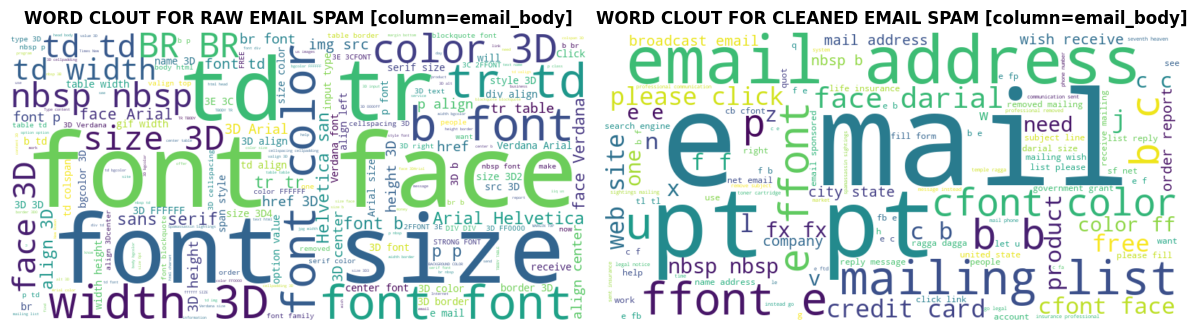

In [10]:
for idx, label in enumerate(labels):
    columns = ['subject', 'email_body']

    for column in columns:
        text_raw = " ".join(data_raw_df[data_raw_df.label == idx][column])
        text_cleaned = " ".join(data_cleaned_df[data_cleaned_df.label == idx][column].apply(lambda x : ' '.join(x)))

        wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text_raw)
        wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text_cleaned)

        plt.figure(figsize = (12, 8)) 

        # Plot the first word cloud
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud1, interpolation='bilinear')
        plt.axis('off')
        plt.title("WORD CLOUT FOR RAW EMAIL " + label.upper() + " [column=" + column + "]", weight='bold')

        # Plot the second word cloud
        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud2, interpolation='bilinear')
        plt.axis('off')
        plt.title("WORD CLOUT FOR CLEANED EMAIL " + label.upper() + " [column=" + column + "]", weight='bold')

        # Show the plot
        plt.tight_layout()
        plt.show()

## Building Model (uncleaned data)

Note: Make sure to run 3 iterations of tuning and explain your rationale for the tuning approaches used each iteration

In [11]:
# Split independent variables and dependent variable
X_raw = data_raw_df.drop(['label'], axis=1)
y_raw = data_raw_df['label']

X_raw.shape, y_raw.shape

((8597, 4), (8597,))

In [12]:
# Split the data into training and testing datasets 
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, test_size=0.30, random_state=42)

In [13]:
# Vectorize the text data
vectorizer = CountVectorizer()
transformer = make_column_transformer((vectorizer, 'subject'), (vectorizer, 'to'), (vectorizer, 'from'), (vectorizer, 'email_body'))

X_raw_train_vec = transformer.fit_transform(X_raw_train)
X_raw_test_vec = transformer.transform(X_raw_test)

X_raw_train_vec.shape, X_raw_test_vec.shape

((6017, 107190), (2580, 107190))

In [14]:
# Train a Multinomial Naive Bayes classifier
classifier1 = MultinomialNB()
classifier1.fit(X_raw_train_vec, y_raw_train)

MultinomialNB()

### Model Evaluation

Note: Evaluate both test and train data. Make sure there are enough data points in the test set (>500) for Confusion Matrix, AUC etc.

In [15]:
# Predict using the trained classifier
y_raw_pred = classifier1.predict(X_raw_test_vec)
print(y_raw_pred)

[0 0 0 ... 1 0 0]


In [16]:
# Evaluate the classifier
accuracy = accuracy_score(y_raw_test, y_raw_pred)
report = classification_report(y_raw_test, y_raw_pred)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(report)

Accuracy: 0.9682170542635659

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2030
           1       0.98      0.87      0.92       550

    accuracy                           0.97      2580
   macro avg       0.97      0.93      0.95      2580
weighted avg       0.97      0.97      0.97      2580



## Building Model (cleaned data)

Note: Make sure to run 3 iterations of tuning and explain your rationale for the tuning approaches used each iteration

In [17]:
# Split independent variables and dependent variable
X_cleaned = data_cleaned_df.drop(['label'], axis=1)
y_cleaned = data_cleaned_df['label']

X_cleaned.shape, y_cleaned.shape

((8597, 4), (8597,))

In [18]:
X_cleaned = X_cleaned.applymap(lambda x : ' '.join(x))
X_cleaned.head(1)

,subject,to,from,email_body
0,new sequence window,deepeddy.com,munnari.oz.au,date tue aug chris garrigues message-id hoping people additional sequence notice purely cosmetic change well first exmh latest one change start get read flist totalcount unseen element array executing totalcount unseen-sequence flaginner spool iconspool labelup else flaginner icondown labeldown procedure flag msgseen line invoked within flag msgseen procedure msgseen line invoked within msgseen procedure msgshow line invoked within msgshow procedure msgchange line invoked within msgchange show invoked within time list msgchange procedure msg change line invoked within msg change id procedure msg show line invoked within msg show cur eval body line invoked within eval procedure folderchange line invoked within folderchange inbox msg show cur invoked within time list folderchange procedure folder change line invoked within folder change folder procedure exmh line invoked within exmh script probably related unseen sequence anywhere certainly inbox read outstanding mail tried new exmh second used key binding msg markunseen seem exist sure replace obviously way sequence menu mark unseen menu entry message menu still wanting function well sequence defined window widen display sequence chance lengthen instead like exmh stuff nice column fit display better use detached folder list one column main exmh window take full screen top bottom le half width etc space sequence unseen window long remain nice narrow window best would sequence could ordered preference one fit would fall bottom shown would also prefer window unusual background colouring one constant colour running unseen window background black root window black border decoration made sticky appearance like folder unseen message count written root window sticky small display follows around see new mail need processing also find tend bunch sequence ever occur one folder forgotten ever created addition sequence always show sequence never show preference show sequence occur one folder would useful sequence occor folder visiting appear list folder current keep list size somewhat manageable remaining productive quite often use sequence remember particular message folder name used one message give handle message remains folder packed sorted etc updated exmh time sure next one new new since sequence menu bar new flist search contains unseen urgent would useful contained sequence folder happens defined new sequence entry would also useful mark message sequence name previously exist done using search pick interface clumsy way actually could try entering sequence name pick box single message number range n-n list message pick attribute get syntax error expression int hit executing expr int procedure ftoc findmsg line invoked within ftoc findmsg procedure ftoc findmsgs line invoked within ftoc findmsgs procedure ftoc pickmsgs line invoked within ftoc pickmsgs id addtosel procedure pickinner line invoked within pickinner exec pick inbox list sequence mercury uplevel body line invoked within uplevel procedure busycursorinner line invoked within busycursorinner procedure busycursorhack line invoked within busycursorhack cursor arm line invoked within switch style icon busyicon cursorall busycursor cursor busycursorhack default eval procedure busy line invoked within busy pickinner procedure pick line invoked within pick invoked within pick pick invoke uplevel body line invoked within uplevel list invoke procedure tkbuttonup line invoked within tkbuttonup pick pick command bound event age since last though tried adding subject pick easy know message made difference look something saying hit similar also changed ftoc colorization discussed briefly list week ago chance making current message little brighter background make stand fraction maybe apparent many use small font everywhere background ftoc line wide hope help kre exmh-workers mailing list


In [19]:
# Split the data into training and testing datasets 
X_cleaned_train, X_cleaned_test, y_cleaned_train, y_cleaned_test = train_test_split(X_cleaned, y_cleaned, test_size=0.30, random_state=42)

In [20]:
# Vectorize the text data
vectorizer = CountVectorizer()
transformer = make_column_transformer((vectorizer, 'subject'), (vectorizer, 'to'), (vectorizer, 'from'), (vectorizer, 'email_body'))

X_cleaned_train_vec = transformer.fit_transform(X_cleaned_train)
X_cleaned_test_vec = transformer.transform(X_cleaned_test)

X_cleaned_train_vec.shape, X_cleaned_test_vec.shape

((6017, 115497), (2580, 115497))

In [21]:
# Train a Multinomial Naive Bayes classifier
classifier2 = MultinomialNB()
classifier2.fit(X_cleaned_train_vec, y_cleaned_train)

MultinomialNB()

### Model Evaluation

Note: Evaludate both test and train data. Make sure there are enough data points in the test set (>500) for Confusion Matrix, AUC etc.

In [23]:
# Predict using the trained classifier
y_cleaned_pred = classifier2.predict(X_cleaned_test_vec)
print(y_cleaned_pred)

[0 0 1 ... 0 0 0]


In [24]:
# Evaluate the classifier
accuracy = accuracy_score(y_cleaned_test, y_cleaned_pred)
report = classification_report(y_cleaned_test, y_cleaned_pred)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(report)

Accuracy: 0.9713178294573643

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2030
           1       0.99      0.87      0.93       550

    accuracy                           0.97      2580
   macro avg       0.98      0.94      0.96      2580
weighted avg       0.97      0.97      0.97      2580



## Conclusion

Note: Include what else could be done to tune the model and how it would have helped (w/ some numbers)

## References
- https://coderzcolumn.com/tutorials/python/email-how-to-represent-an-email-message-in-python